In [1]:
import os
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from scipy.fftpack import fft
from statsmodels.tsa.stattools import adfuller
import MetaTrader5 as mt5



import sys
import os
import warnings
from pathlib import Path

# ---------------------------------------------------------------------------
# 1) SET PROJECT ROOT AND UPDATE PATH/WORKING DIRECTORY
# ---------------------------------------------------------------------------
project_root = Path.cwd().parent.parent  # Adjust if your notebook is in notebooks/time_series
sys.path.append(str(project_root))
os.chdir(str(project_root))
warnings.filterwarnings("ignore")

# Import modules for data loading and feature engineering
from data.data_loader import get_data_mt5
from features.feature_engineering import add_all_ta_features
from features.labeling_schemes import calculate_future_returns


In [2]:
import MetaTrader5 as mt5

# Initialize connection to MetaTrader 5
if not mt5.initialize():
    print("initialize() failed, error code =", mt5.last_error())
    quit()

# Retrieve all available symbols
symbols = mt5.symbols_get()

# Print the names of all symbols
for symbol in symbols:
    print(symbol.name)

# Shutdown MT5 connection
mt5.shutdown()


EURUSD
GBPUSD
USDCHF
USDJPY
USDCAD
AUDUSD
AUDNZD
AUDCAD
AUDCHF
AUDJPY
CHFJPY
EURGBP
EURAUD
EURJPY
EURCHF
EURNZD
EURCAD
GBPCHF
GBPJPY
CADCHF
CADJPY
GBPAUD
GBPCAD
GBPNZD
NZDCAD
NZDCHF
NZDJPY
NZDUSD
USDSGD
AUDSGD
CHFSGD
EURDKK
EURHKD
EURNOK
EURPLN
EURSEK
EURSGD
EURTRY
EURZAR
GBPDKK
GBPNOK
GBPSEK
GBPSGD
GBPTRY
NOKJPY
NOKSEK
SEKJPY
SGDJPY
USDCNH
USDCZK
USDDKK
USDHKD
USDHUF
USDMXN
USDNOK
USDPLN
USDRUB
USDSEK
USDTHB
USDTRY
USDZAR
AUS200
CHINA50
ES35
STOXX50
F40
HK50
IT40
JP225
UK100
US2000
US30
US500
USTEC
XAGEUR
XAGUSD
XAUEUR
XAUUSD
XPDUSD
XPTUSD
XBRUSD
XNGUSD
XTIUSD
BTCUSD
BCHUSD
ETHUSD
LTCUSD
DSHUSD
AAPL.NAS
ADBE.NAS
ADI.NAS
ADP.NAS
AMAT.NAS
AMGN.NAS
AMZN.NAS
AVGO.NAS
BKNG.NAS
BIIB.NAS
CELG.NAS
CHTR.NAS
CMCSA.NAS
CME.NAS
COST.NAS
CRON.NAS
CSCO.NAS
CSX.NAS
CTSH.NAS
EA.NAS
EBAY.NAS
EQIX.NAS
FOX.NAS
FOXA.NAS
GILD.NAS
GOOG.NAS
INTC.NAS
INTU.NAS
ISRG.NAS
KHC.NAS
MAR.NAS
MDLZ.NAS
MSFT.NAS
MU.NAS
NFLX.NAS
NVDA.NAS
PEP.NAS
PYPL.NAS
QCOM.NAS
REGN.NAS
SBUX.NAS
SHPG.NAS
TFCF.NAS
TFCFA.NAS
TLRY.NAS
TM

True

In [7]:
# Initialize MetaTrader 5
if not mt5.initialize():
    print("Failed to initialize MT5")
else:
    SYMBOL = "BTCUSD"  # Modify to analyze different assets
    TIMEFRAME = mt5.TIMEFRAME_H4
    N_BARS = 1000
    df = get_data_mt5(symbol=SYMBOL, timeframe=TIMEFRAME, n_bars=N_BARS)
    mt5.shutdown()

# Apply technical indicators and feature engineering
df = add_all_ta_features(df)
df = calculate_future_returns(df).dropna(subset=["future_returns"])

# Ensure indicator columns exist
available_features = df.columns.tolist()
selected_features = [col for col in ["close", "rsi_14", "macd", "stoch_%K", "volume"] if col in available_features]

df_selected = df[selected_features].dropna()
if not df_selected.empty:
    fig = px.scatter_matrix(df_selected)
    fig.show()
else:
    print("No selected features are available in the dataset.")

# Basic Data Overview
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())


c:\Users\moham\miniconda3\envs\dl\Lib\site-packages\ta\trend.py:1030: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`




Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999 entries, 2024-09-14 08:00:00 to 2025-02-27 16:00:00
Data columns (total 94 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   open                       999 non-null    float64
 1   high                       999 non-null    float64
 2   low                        999 non-null    float64
 3   close                      999 non-null    float64
 4   tick_volume                999 non-null    uint64 
 5   spread                     999 non-null    int32  
 6   real_volume                999 non-null    uint64 
 7   volume_adi                 999 non-null    float64
 8   volume_obv                 999 non-null    uint64 
 9   volume_cmf                 999 non-null    float64
 10  volume_fi                  999 non-null    float64
 11  volume_em                  999 non-null    float64
 12  volume_sma_em              999 non-null    float64
 13

In [3]:
# Plot Raw Data
fig = px.line(df, x=df.index, y="close", title=f"Raw Closing Price Data for {SYMBOL}")
fig.show()

In [8]:
# Plot a subset of technical indicators
for indicator in selected_features:
    if indicator in df.columns and indicator != "close":
        fig = px.line(df, x=df.index, y=indicator, title=f"{indicator} Indicator for {SYMBOL}")
        fig.show()

In [9]:
# Define the list of indicators you want to test
indicators = ["rsi_14", "macd", "stoch_%K", "bollinger_bands", "ema_50", "sma_200"]  # Add more indicators as needed

# Plot a subset of technical indicators
for indicator in selected_features:
    if indicator in df.columns and indicator != "close":
        fig = px.line(df, x=df.index, y=indicator, title=f"{indicator} Indicator for {SYMBOL}")
        fig.show()

# Plot Future Returns
fig = px.line(df, x=df.index, y="future_returns", title=f"Future Returns for {SYMBOL}")
fig.show()

C:\Users\moham\AppData\Local\Temp\ipykernel_1008\1032030309.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\moham\AppData\Local\Temp\ipykernel_1008\1032030309.py:6: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



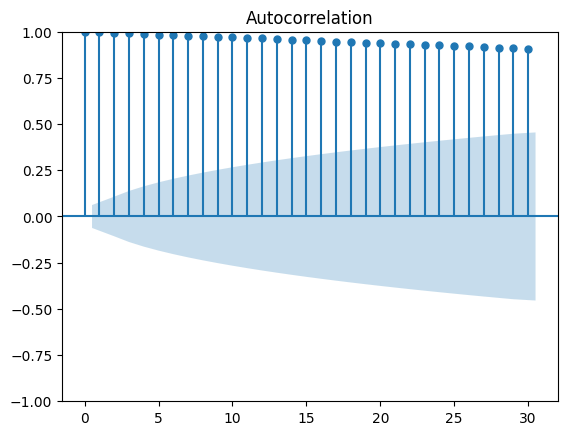

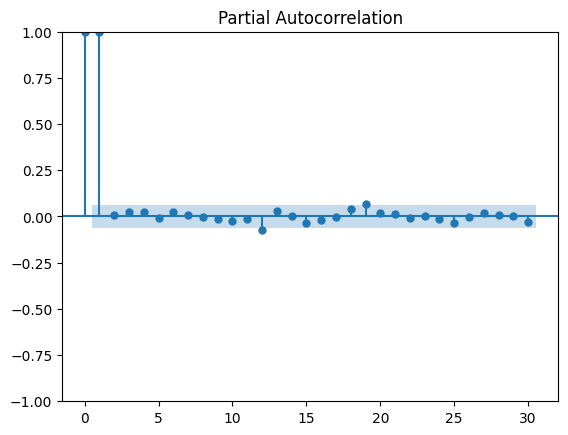

In [11]:
# Autocorrelation & Partial Autocorrelation (ACF & PACF)
def plot_acf_pacf(series, lags=30):
    fig = sm.graphics.tsa.plot_acf(series.dropna(), lags=lags)
    fig.show()
    fig = sm.graphics.tsa.plot_pacf(series.dropna(), lags=lags)
    fig.show()

plot_acf_pacf(df["close"])

In [12]:
# Rolling Mean & Standard Deviation
def plot_rolling_stats(series, window=50):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=series.index, y=series.rolling(window).mean(), name="Rolling Mean", line=dict(color='red')))
    fig.add_trace(go.Scatter(x=series.index, y=series.rolling(window).std(), name="Rolling Std Dev", line=dict(color='blue')))
    fig.update_layout(title="Rolling Mean & Standard Deviation", xaxis_title="Time", yaxis_title="Value")
    fig.show()

plot_rolling_stats(df["close"])

In [13]:
# ADF Test (Stationarity Test)
def adf_test(series):
    result = adfuller(series.dropna())
    print("\nADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The series is likely stationary.")
    else:
        print("The series is likely non-stationary.")

adf_test(df["close"])


ADF Statistic: -1.866096850060274
p-value: 0.3481743770195106
The series is likely non-stationary.


In [3]:
# Fourier Transform for Cyclical Trends
def plot_fourier_transform(series, n_components=20):
    series_values = series.dropna().values
    fft_vals = np.abs(fft(series_values))
    freqs = np.fft.fftfreq(len(series_values))
    fig = px.line(x=freqs[:n_components], y=fft_vals[:n_components], title="Fourier Transform - Top Components",
                  labels={"x": "Frequency", "y": "Magnitude"})
    fig.show()

plot_fourier_transform(df["close"])

In [4]:
# Lagged Features Correlation Matrix
def plot_lagged_correlation(df, col="close", max_lag=10):
    lagged_df = pd.DataFrame({f"lag_{i}": df[col].shift(i) for i in range(1, max_lag+1)})
    lagged_df["original"] = df[col]
    corr_matrix = lagged_df.corr()
    fig = px.imshow(corr_matrix, text_auto=True, title="Correlation Matrix of Lagged Features")
    fig.show()

plot_lagged_correlation(df, col="close")

print(f"EDA Completed for {SYMBOL}! Use these insights to refine feature engineering and model selection.")

EDA Completed for BTCUSD! Use these insights to refine feature engineering and model selection.
